## Bibliotecas e módulos

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import csv
import numpy as np

import sklearn.preprocessing as preproc

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture

from sklearn import metrics

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

## Função para leitura dos dados

In [2]:
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

## Conjunto de dados (World Air Quality Index):
* Dados sobre qualiade do ar - Air Quality Open Data Platform - Worldwide COVID-19 dataset
* Informações adicionais: https://aqicn.org/data-platform/covid19/
* Os dados coletados são os mais próximos do dia 15/março/2020
* Variáveis:
    * Latitude
    * Longitude
    * wind-speed ($m/s$)
    * wind-gust ($m/s$)
    * humidity ($\%$)
    * dew ($C$)
    * pressure ($mb$ - millibars)
    * precipitation (inch $1.0 inch \approx 25.4 mm$)
    * temperature ($C$)
    * CO - monóxido de carbono ($\mu g/m^3 \rightarrow$ EPA Standard)
    * pm10 - particulas respiráveis ($\mu g/m^3 \rightarrow$ EPA Standard)
    * pm25 - particulas finas ($\mu g/m^3 \rightarrow$ EPA Standard)
    * SO2 - dióxido de enxofre ($\mu g/m^3 \rightarrow$ EPA Standard)
    * NO2 - dióxido de nitrogênio ($\mu g/m^3 \rightarrow$ EPA Standard)
    * O3 - ozônio ($\mu g/m^3 \rightarrow$ EPA Standard)

* Detalhes sobre as unidades: https://weather.gladstonefamily.net/CWOP_Guide.pdf
* EPA Standard: https://en.wikipedia.org/wiki/National_Ambient_Air_Quality_Standards

In [3]:
path = 'waqi.csv'

#Não existe rótulo (y) válido para este conjunto de dados
_,xOrig = read_class_data(path) 

#Escolha dos atributos
Atributos = [2,3,4,5,6,7,8,9,10,11,12,13,14]

#Normalização dos dados...
x = np.copy(xOrig[:,Atributos])
x = preproc.normalize(x, norm='max', axis=0, copy=True)

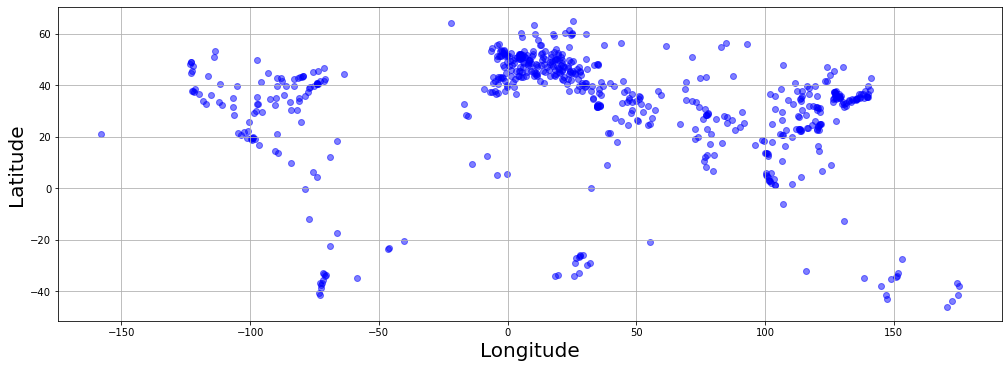

In [5]:
FS = (15,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])

ax.scatter( xOrig[:,1], xOrig[:,0], c='blue', alpha=0.5)
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)

ax.set_aspect('equal', 'box')

ax.grid(True)

## Parametrização e execução

In [6]:
n_clusters = 4 #Usar até 8 ou acrescentar mais cores no vetor 'cores' 
epsilon = 0.0001
#----------

#===Instanciação e execução de agrupamento hierárquico
aglom = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
res = aglom.fit(x)
agrupWard = res.labels_

#===Instanciação e execução do algoritmo K-Médias
km = KMeans(n_clusters=n_clusters, max_iter=1000, tol=epsilon)
agrupKM = km.fit_predict(x)

#===Instanciação e modelagem via GMM
gmm = mixture.GaussianMixture(n_components=n_clusters)
gmm.fit(x)
agrup = []
for i in range(x.shape[0]): agrup.append( np.argmax( gmm.predict_proba( [x[i,:]] ) ) )
agrupGMM = np.array(agrup)

## Avaliação de agrupamentos sem uso de referência
* Coeficiente silhueta ($SC$)
* Indice de Calinski-Harabasz ($CHI$)

In [7]:
sc_ward = metrics.silhouette_score(x, agrupWard, metric='euclidean')
chi_ward = metrics.calinski_harabasz_score(x, agrupWard)

sc_km = metrics.silhouette_score(x, agrupKM, metric='euclidean')
chi_km = metrics.calinski_harabasz_score(x, agrupKM)

sc_gmm = metrics.silhouette_score(x, agrupGMM, metric='euclidean')
chi_gmm = metrics.calinski_harabasz_score(x, agrupGMM)

print("---Método de Ward---")
print("SC: %f   CHI: %f\n\n"%(sc_ward,chi_ward))

print("---K-Médias---")
print("SC: %f   CHI: %f\n\n"%(sc_km,chi_km))

print("---Agrupamento via GMM---")
print("SC: %f   CHI: %f"%(sc_gmm,chi_gmm))

---Método de Ward---
SC: 0.234170   CHI: 218.306862


---K-Médias---
SC: 0.269936   CHI: 264.834568


---Agrupamento via GMM---
SC: 0.065587   CHI: 22.596494


## Visualização do resultado de agrupamento

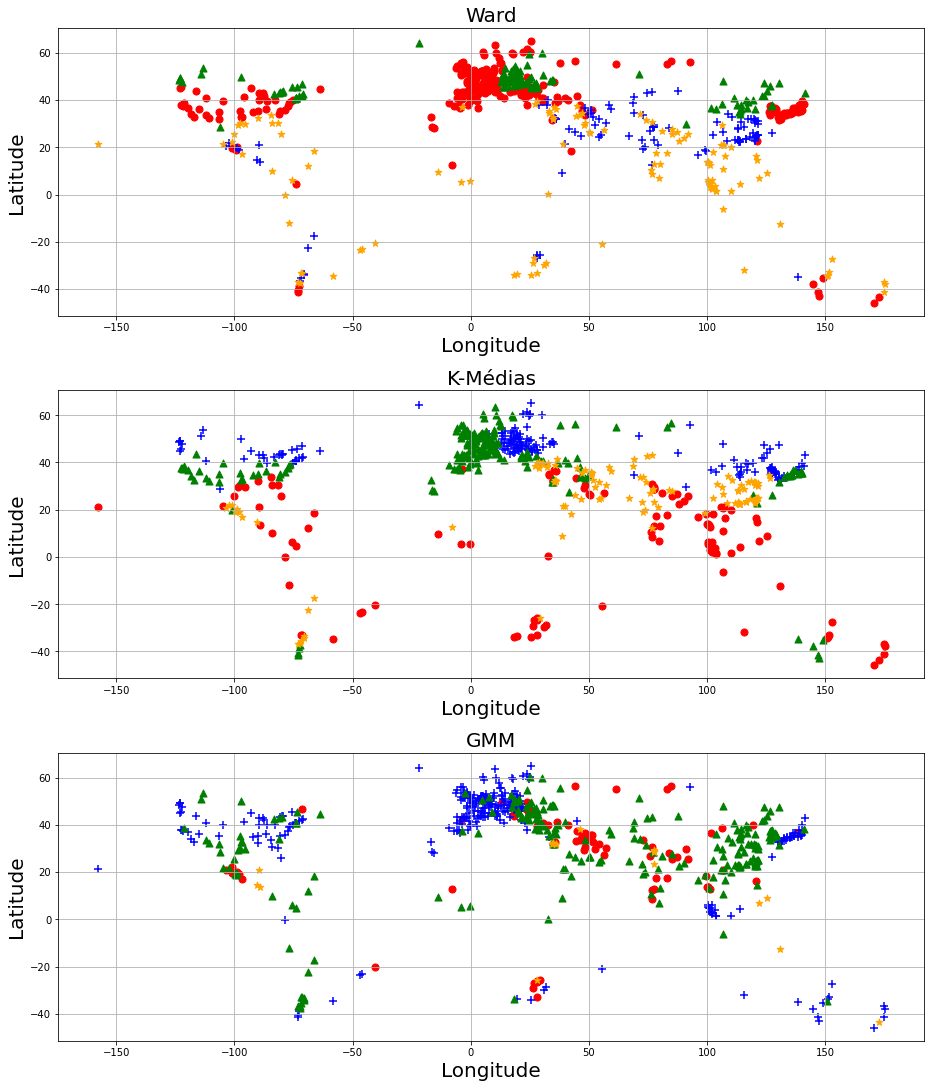

In [8]:
FS = (15,15) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)

cores = ['red','blue','green','orange','magenta','cyan','darkred','grey']
marcadores = ['o','+','^','*','D','x','p','h']

#Ward
ax = fig.add_subplot(spec[0,0])
for i in range(n_clusters):
    pos = np.where( agrupWard == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('Ward',fontsize=20)
ax.grid(True) 

#K-Médias
ax = fig.add_subplot(spec[1,0])
for i in range(n_clusters):
    pos = np.where( agrupKM == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('K-Médias',fontsize=20)
ax.grid(True) 

#GMM
ax = fig.add_subplot(spec[2,0])
for i in range(n_clusters):
    pos = np.where( agrupGMM == i )
    ax.scatter(xOrig[pos, 1], xOrig[pos, 0], marker=marcadores[i], c=cores[i], s=50)    
ax.set_xlabel('Longitude',fontsize=20)
ax.set_ylabel('Latitude',fontsize=20)
ax.set_aspect('equal', 'box')
ax.set_title('GMM',fontsize=20)
ax.grid(True) 


#plt.savefig(path_out,dpi=300)
plt.show()

## Seleção de parametro
* Teste sobre o K-Médias
* Investigação sobre $k \in \{2,\ldots,80\}$

In [9]:
vecK = []
vecSC = []
vecCHI = []
for k in range(2,81):
    #Instancia e agrupa os dados...
    km = KMeans(n_clusters=k, max_iter=1000, tol=epsilon)
    agrupKM = km.fit_predict(x)
    sc = metrics.silhouette_score(x, agrupKM, metric='euclidean')
    chi = metrics.calinski_harabasz_score(x, agrupKM)
    vecK.append(k)
    vecSC.append(sc)
    vecCHI.append(chi)

Text(0, 0.5, '$CHI$')

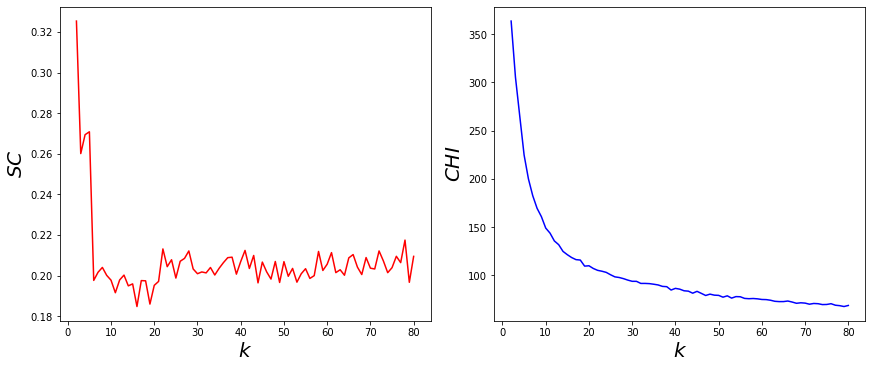

In [10]:
FS = (12,5) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#Gráfico SC
ax = fig.add_subplot(spec[0,0])
ax.plot(vecK,vecSC,'r-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$SC$',fontsize=20)

#Gráfico CHI
ax = fig.add_subplot(spec[0,1])
ax.plot(vecK,vecCHI,'b-')
ax.set_xlabel('$k$',fontsize=20)
ax.set_ylabel('$CHI$',fontsize=20)

## Usando uma "derivada" do comportamento de $CHI$
* Pode revelar algo importante!
* A partir de qual valor de $k$ há estabilização?

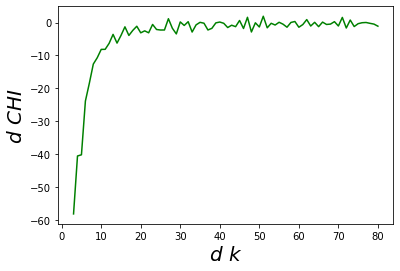

In [10]:
vecDerCHI = []
for i in range(1,len(vecCHI)): vecDerCHI.append( vecCHI[i] - vecCHI[i-1])
    
plt.plot(vecK[1:],vecDerCHI,'g-')
plt.xlabel('$d \ k$',fontsize=20)
plt.ylabel('$d \ CHI$',fontsize=20)
plt.show()

## Comparação entre resultados de agrupamento via Medida $V$
* Vamos considerar pares de resultados
    * Ward - K-Médias
    * Ward - GMM
    * K-Médias - GMM

In [11]:
ho_ward_km ,co_ward_km,vm_ward_km = metrics.homogeneity_completeness_v_measure(agrupWard, agrupKM)
ho_ward_gmm ,co_ward_gmm,vm_ward_gmm = metrics.homogeneity_completeness_v_measure(agrupWard, agrupGMM)
ho_km_gmm ,co_km_gmm,vm_km_gmm = metrics.homogeneity_completeness_v_measure(agrupKM, agrupGMM)
ho_gmm_km ,co_gmm_km,vm_gmm_km = metrics.homogeneity_completeness_v_measure(agrupGMM,agrupKM)

print('Ward - K-Médias',vm_ward_km)
print('Ward - GMM',vm_ward_gmm)
print('K-Médias - GMM',vm_km_gmm)
print('GMM - K-Médias',vm_gmm_km) #<-------deve ser simétrico!

Ward - K-Médias 0.44574824219201575
Ward - GMM 0.1416178430610356
K-Médias - GMM 0.2562864248906052
GMM - K-Médias 0.2562864248906052
